# INF-475 - Modelamiento Estocástico y Simulación
## Proyecto: Analisis de la propagación de Incendios Forestales
### Daniel San Martín

## Modelo Físico

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from wildfire.fire import Fire
from wildfire import plots as p
import ipywidgets as widgets
import warnings
warnings.filterwarnings("ignore") 

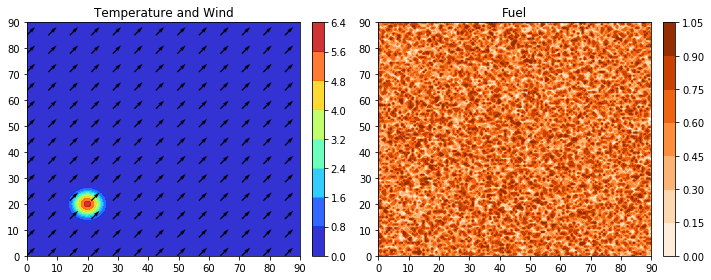

In [5]:
M, N = 128, 128
L = 3000 # Timesteps
dt = 1e-2 # dt
xa, xb = 0, 90 # x domain limit
ya, yb = 0, 90 # y domain limit
x = np.linspace(xa, xb, N) # x domain
y = np.linspace(ya, yb, M) # y domain
t = np.linspace(0, dt*L, L) # t domain

# Temperature initial condition
u0 = lambda x, y: 6e0*np.exp(-5e-2*((x-20)**2 + (y-20)**2)) 

# Fuel initial condition
np.random.seed(666)
b0 = lambda x, y: np.round(np.random.uniform(size=(x.shape)), decimals=2)

# Wind effect
gamma = 1
v1 = lambda x, y, t: gamma * np.cos(np.pi/4 + x*0) # 300
v2 = lambda x, y, t: gamma * np.sin(np.pi/4 + x*0) # 300
V = (v1, v2)

# Parameters
kappa = 1e-1 # diffusion coefficient
epsilon = 3e-1 # inverse of activation energy
upc = 3e0 # u phase change
q = 1 # reaction heat
alpha = 1e-3 # natural convection

# Meshes for initial condition plots
X, Y = np.meshgrid(x, y)

# Plot initial conditions
p.plotIC(X, Y, u0, b0, V, T=None, top=None)

# Parameters for the model
parameters = {'u0': u0, 'beta0': b0, 'v': V, 'kappa': kappa, 'epsilon': epsilon, 'upc': upc, 
    'q': q, 'alpha': alpha, 'x': x, 'y': y, 't': t, 'sparse': True, 'show': False,'complete': False }

ct = Fire(parameters)

In [6]:
# Solve System
U, B = ct.solvePDE('fd', 'rk4')

In [8]:
widgets.interact(p.plotUB, t=widgets.IntSlider(min=0, max=len(U)-1, continuous_update=False), 
    X=widgets.fixed(X), Y=widgets.fixed(Y), U=widgets.fixed(U), B=widgets.fixed(B), V=widgets.fixed(V))

interactive(children=(IntSlider(value=0, continuous_update=False, description='t', max=2999), Output()), _dom_classes=('widget-interact',))

<function wildfire.plots.plotUB>

## Ajustar/predecir factores asociados a los parámetros del modelo

### Viento 

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.style.use('bmh')

In [89]:
def acf_pacf(serie, lags_=50):
    fig, axes = plt.subplots(1, 2)
    plot_acf(serie, lags=lags_, ax=axes[0])
    plot_pacf(serie, lags=lags_, ax=axes[1])
    fig.set_size_inches(16, 4)
    plt.show()

In [82]:
df = pd.read_csv('data/originald08.csv')
df = df.iloc[:, [0,4,7]]
df.columns = ['timestamp', 'speed', 'direction']
df.reset_index(inplace=True)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')

In [84]:
df[['speed', 'direction']].describe()

,speed,direction
count,232760.000000,232760.000000
mean,6.830592,120.655400
std,3.529807,123.753194
min,0.000000,1.000000
25%,4.170000,15.000000
50%,6.800000,38.000000
75%,9.000000,216.000000
max,25.660000,360.000000


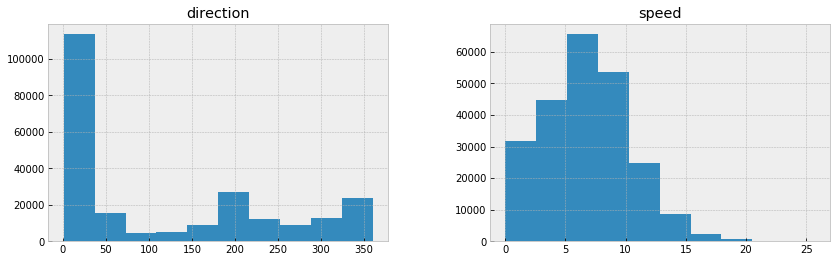

In [86]:
df[['speed', 'direction']].hist(figsize=(14, 4))
plt.show()

In [248]:
freq = 3
speed = pd.Series(df['speed'].loc['2017'].iloc[::freq]) # Cada media hora

In [194]:
speed.tail(10)

timestamp
2017-06-20     2.96
2017-06-21    12.37
2017-06-22     9.58
2017-06-23    11.45
2017-06-24     9.19
2017-06-25    14.57
2017-06-26    12.13
2017-06-27    18.75
2017-06-28    15.78
2017-06-29    11.06
Name: speed, dtype: float64

#### Velocidad

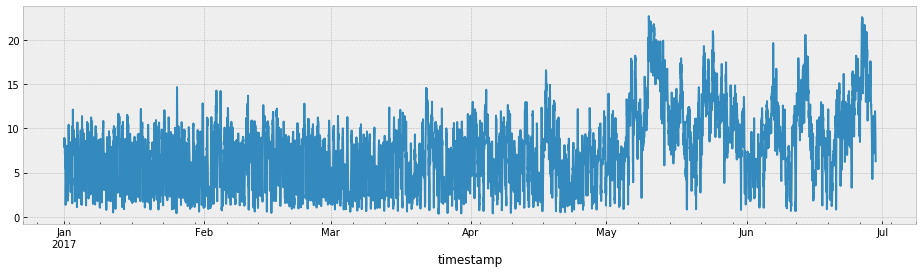

In [202]:
speed.plot(figsize=(16, 4))
plt.show()

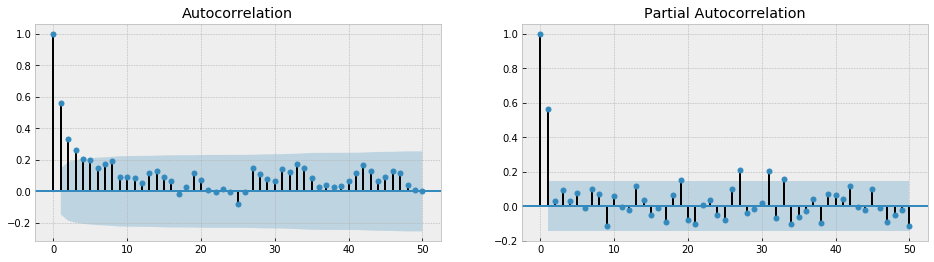

In [198]:
acf_pacf(speed)

In [216]:
diff_speed = pd.Series(np.diff(speed, 1), index=speed.index[1:])

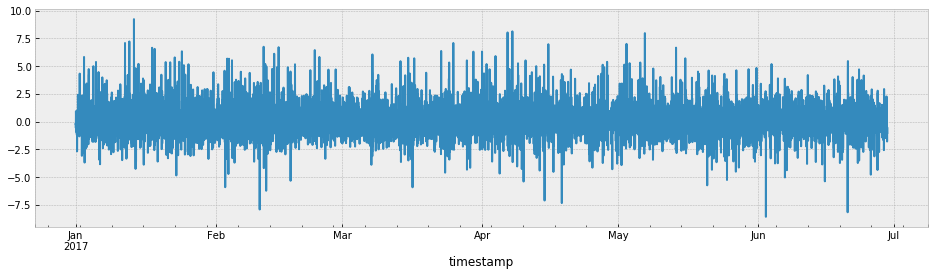

In [219]:
diff_speed.plot(figsize=(16, 4))
plt.show()

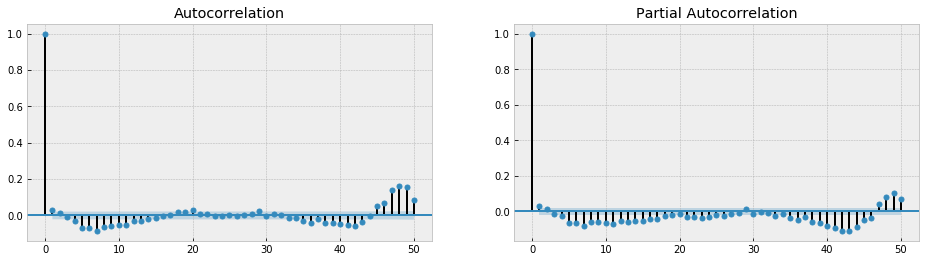

In [211]:
acf_pacf(diff_speed)

In [155]:
decomp = seasonal_decompose(speed, freq=3*12)

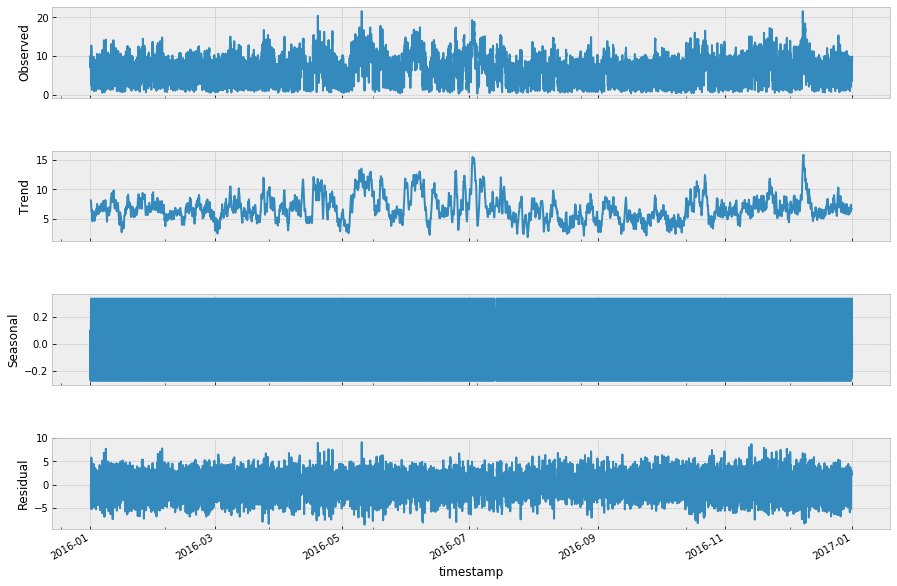

In [156]:
fig = decomp.plot()
fig.set_size_inches(14,10)
plt.show()

In [157]:
y = pd.Series(speed - decomp.trend).dropna()

In [158]:
y = pd.Series(np.diff(y, 1))

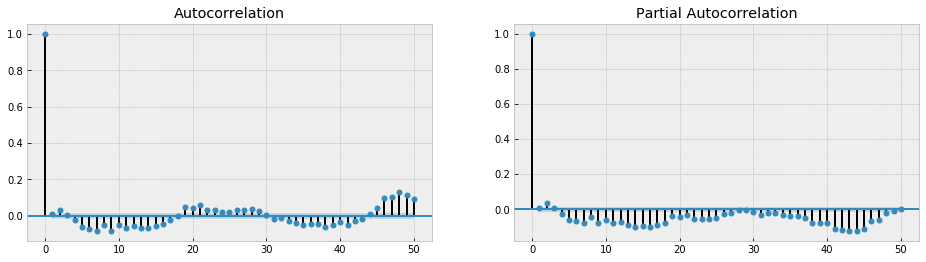

In [159]:
acf_pacf(y)

#### Dirección

In [249]:
direc = pd.Series(df['direction'].loc['2017-01':'2017-05'].iloc[::freq]) # Cada media hora

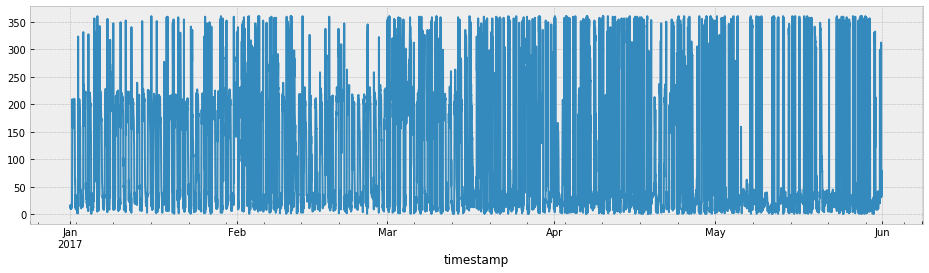

In [255]:
direc.plot(figsize=(16, 4))
plt.show()

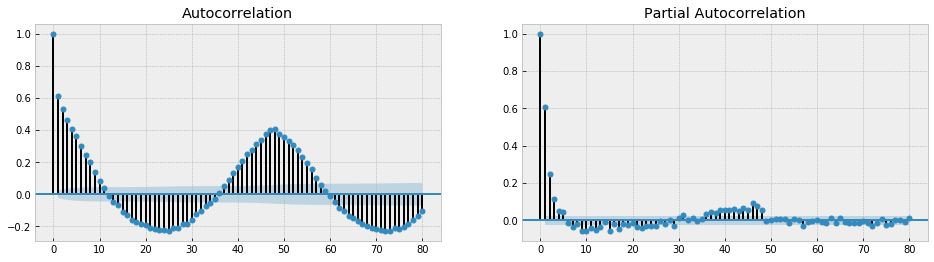

In [256]:
acf_pacf(direc, lags_=80)

El gráfico de autocorrelación muestra un comportamiento estacional en la serie de direcciones que se repite de forma diaria.

In [257]:
direc_shifted = pd.Series(direc.shift(48) - direc).dropna()

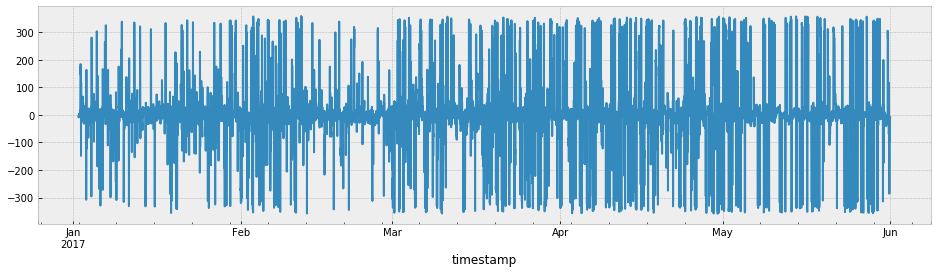

In [258]:
direc_shifted.plot(figsize=(16, 4))
plt.show()

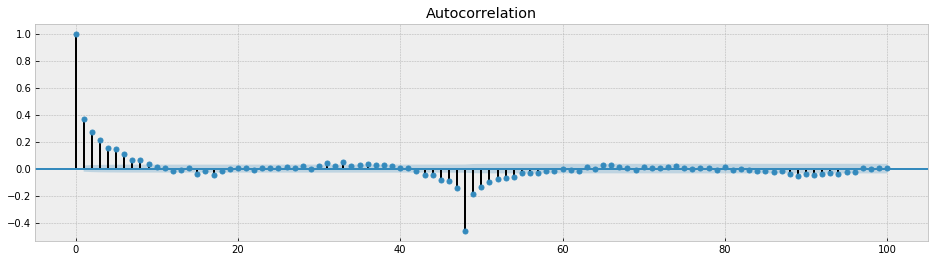

In [259]:
fig = plot_acf(direc_shifted, lags=100)
fig.set_size_inches(16, 4)
plt.show()

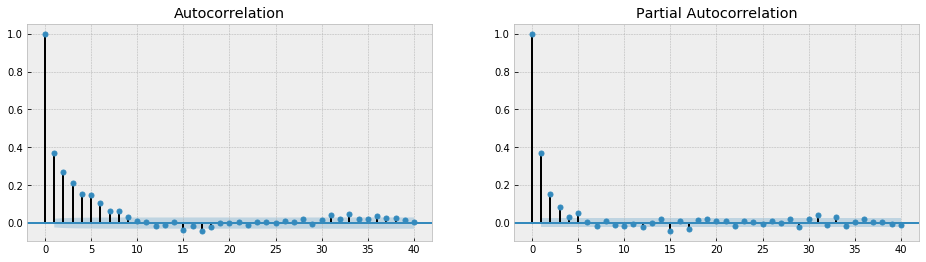

In [260]:
acf_pacf(direc_shifted, lags_=40)

* Estacional: $D=1$, $Q=2$ MA
* No estacional: $p=8$

$ARIMA(8,0,0)\times(0,1,2)_{48}$

In [261]:
import statsmodels.api as sm 
sarima = sm.tsa.statespace.SARIMAX(direc,
                                order=(8, 0, 0),
                                seasonal_order=(0,1,2,48),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

sarima_model = sarima.fit()
sarima_model.summary()

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  % freq, ValueWarning)


KeyboardInterrupt: 

### Temperatura ambiental

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

In [10]:
# Farenheit to Celsius
FtoC = lambda t: np.round((t - 32) * (5 / 9), 2)

Datos obtenidos de https://www7.ncdc.noaa.gov/CDO/cdoselect.cmd?datasetabbv=GSOD, estación de Viña del Mar 10/2009 a 07/2018. Según la descripción del dataset son valores reales que corresponden a la temperatura promedio del día en grados Fahrenheit.

In [22]:
data = pd.read_csv('data/CDO5622797695969.csv') # Read data
data.rename(columns=lambda i: i.strip(), inplace=True) # Clean white spaces in header
df = data[['YEARMODA','TEMP']]
df['TEMP'] = df['TEMP'].apply(FtoC)
df.head() # Show some values

,YEARMODA,TEMP
0,20091031,14.28
1,20091101,14.50
2,20091106,18.00
3,20091107,12.78
4,20091108,14.56


In [23]:
df.describe()

,YEARMODA,TEMP
count,2.126000e+03,2126.000000
mean,2.013885e+07,13.944299
std,2.998035e+04,3.032612
min,2.009103e+07,5.560000
25%,2.011050e+07,11.720000
50%,2.015081e+07,13.830000
75%,2.017012e+07,16.170000
max,2.018073e+07,24.940000


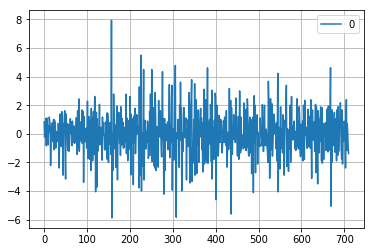

In [38]:
year_start = int(df.index[df['YEARMODA'] == 20160101][0])
year_end = int(df.index[df['YEARMODA'] == 20171231][0])
train = df.loc[year_start:year_end+1] # Get data 2016 - 2017
test = df.loc[year_end:] # Test data from 2018
#tmp = FtoC(train['TEMP']) # Transform to celsius
x_train = train['TEMP'] # - train.mean() # Center data
x_log = np.log(x_train)
x_diff = pd.DataFrame(np.diff(x_train, n=1))
#y = pd.DataFrame(np.diff(x_train, n=1))
#y = pd.DataFrame(np.diff(x_train, n=1))
y = x_diff
y.plot()
plt.grid(True)
plt.show()

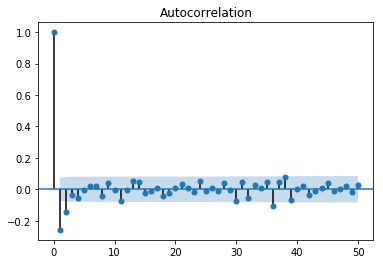

In [41]:
#pd.plotting.autocorrelation_plot(y[:20])
plot_acf(y, lags=50)
plt.show()

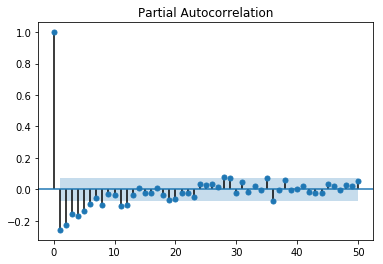

In [42]:
plot_pacf(y, lags=50)
plt.show()

In [ ]:
import warnings
from pandas import Series
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.7)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

In [ ]:
error = evaluate_arima_model(x_train.values, (1, 0, 1))

In [ ]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [ ]:
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(x_train.values, p_values, d_values, q_values)

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
model = ARIMA(y.values, order=(2, 1, 2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

In [ ]:
model_fit.fittedvalues.plot()

In [ ]:
residuals = pd.DataFrame(model_fit.resid, columns=['residual'])
residuals.plot()
plt.legend()
plt.show()

In [ ]:
plt.plot(model_fit.resid + model_fit.fittedvalues)
plt.show()

In [ ]:
model_fit.plot_diagnostics(figsize=(20, 14))
plt.show()